# What is the relationship between sick leave and Job Title?
Cian

Import required modules, basic setup

In [1]:
import numpy as np
import pandas as pd
import pyodbc
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = (7, 7) # default plot size
sns.set_context("talk") # default label size etc.

Connect to AdventureWorks database & retrieve data

In [2]:
query = """
SELECT e.BusinessEntityID AS id
      ,e.JobTitle AS job_title
      ,d.Name AS job_department
      ,d.GroupName AS department_category
      ,CAST(e.OrganizationNode AS varchar(100)) AS organisation_node
      ,e.OrganizationLevel AS organisation_level
      ,e.SickLeaveHours AS sick_leave_hours
  FROM HumanResources.Employee AS e
  JOIN HumanResources.EmployeeDepartmentHistory AS edh
       ON e.BusinessEntityID = edh.BusinessEntityID
  JOIN HumanResources.Department AS d
       ON edh.DepartmentID = d.DepartmentID
 WHERE edh.EndDate IS NULL
"""

conn = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=SNAP-DECISIONS\SQLEXPRESS;"
    "Database=AdventureWorks2019;"
    "Trusted_Connection=yes;"
)
df = pd.read_sql(query, conn)
df.head()

,id,job_title,job_department,department_category,organisation_node,organisation_level,sick_leave_hours
0,1,Chief Executive Officer,Executive,Executive General and Administration,None,NaN,69
1,2,Vice President of Engineering,Engineering,Research and Development,/1/,1.0,20
2,3,Engineering Manager,Engineering,Research and Development,/1/1/,2.0,21
3,4,Senior Tool Designer,Tool Design,Research and Development,/1/1/1/,3.0,80
4,5,Design Engineer,Engineering,Research and Development,/1/1/2/,3.0,22


Alternative data source from CSV

In [3]:
df.to_csv("Q4_data.csv", index=False)
# df = pd.read_csv("Q4_data.csv")

# Data Understanding

Check DataFrame shape

In [4]:
df.shape

(290, 7)

Generate an overview of the dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   290 non-null    int64  
 1   job_title            290 non-null    object 
 2   job_department       290 non-null    object 
 3   department_category  290 non-null    object 
 4   organisation_node    289 non-null    object 
 5   organisation_level   289 non-null    float64
 6   sick_leave_hours     290 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 16.0+ KB


In [6]:
df.describe().round(1)

,id,organisation_level,sick_leave_hours
count,290.0,289.0,290.0
mean,145.5,3.5,45.3
std,83.9,0.8,14.5
min,1.0,1.0,20.0
25%,73.2,3.0,33.0
50%,145.5,4.0,46.0
75%,217.8,4.0,58.0
max,290.0,4.0,80.0


In [7]:
df.describe(include="object")

,job_title,job_department,department_category,organisation_node
count,290,290,290,289
unique,67,16,6,289
top,Production Technician - WC60,Production,Manufacturing,/1/
freq,26,179,185,1


Check for null values

In [8]:
na_in_columns = df.isna().sum()

if na_in_columns.sum() > 0:
    print(f"NA count: {na_in_columns.sum()}")

    columns_with_na = df.columns[na_in_columns == 1]
    print(f"Column(s) containing NA: {', '.join(columns_with_na)}")
else:
    print("No NA values")

NA count: 2
Column(s) containing NA: organisation_node, organisation_level


Check for duplicate values in id column, which should be unique

In [9]:
print(f"Duplicate row count: {df.duplicated(subset='id').sum()}")

Duplicate row count: 0


### Observations:
1. 290 non-duplicate records containing 67 unique job titles in 16 departments across 6 categories
2. Columns **id**, **job_title**, **job_department**, **department_category**, and **organisation_level** contain categorical data
3. Column **sick_leave_hours** contains numerical data
4. Column **organisation_node** contains hierarchical information
5. Columns **organisation_node** and **organisation_level** contain NULL values

# Data Preparation
NULL value in organisation_level is CEO. Level 1 Employees answer directly to CEO. Level 2 employees answer to Level 1 employees, Level 3 to Level 2, and Level 4 to Level 3. Reversing the pattern, it makes sense to consider the CEO a Level 0 employee.

We are not performing an analysis that uses organisation_node, so the NULL value there is ignored.

In [10]:
df["organisation_level"] = df["organisation_level"].fillna(0).apply(int)

**id**, **job_title**, **job_department**, **department_category**, and **organisation_level** contain categorical data and should be stored using the pd.Categorical data type.

In [11]:
to_convert = ["id", "job_title", "job_department", "department_category", 'organisation_level']
df[to_convert] = df[to_convert].astype("category")

# Exploratory Data Analysis
### How is sick leave distributed?

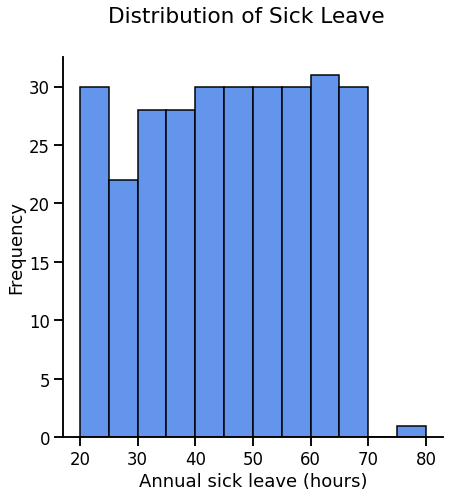

In [12]:
fig, ax = plt.subplots()
sns.despine()

### Plotting ###
df.plot.hist(
    y="sick_leave_hours",
    bins=range(20, 81, 5),
    facecolor="CornflowerBlue",
    edgecolor="black",
    ax=ax,
    legend=False,
)

### Formatting ###
ax.set(
    box_aspect=1,
    xticks=range(20, 81, 10),
    xlabel="Annual sick leave (hours)",
)
fig.suptitle("Distribution of Sick Leave")

### Saving ###
fig.savefig(
    "Q4. Sick Leave histogram.png",
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)

**Observations:**
* Almost flat distribution between 20 and 70 hours
* Dip between 25 and 40 hours
* One outlier at 80 hours

### How is Sick Leave related to Job Title?

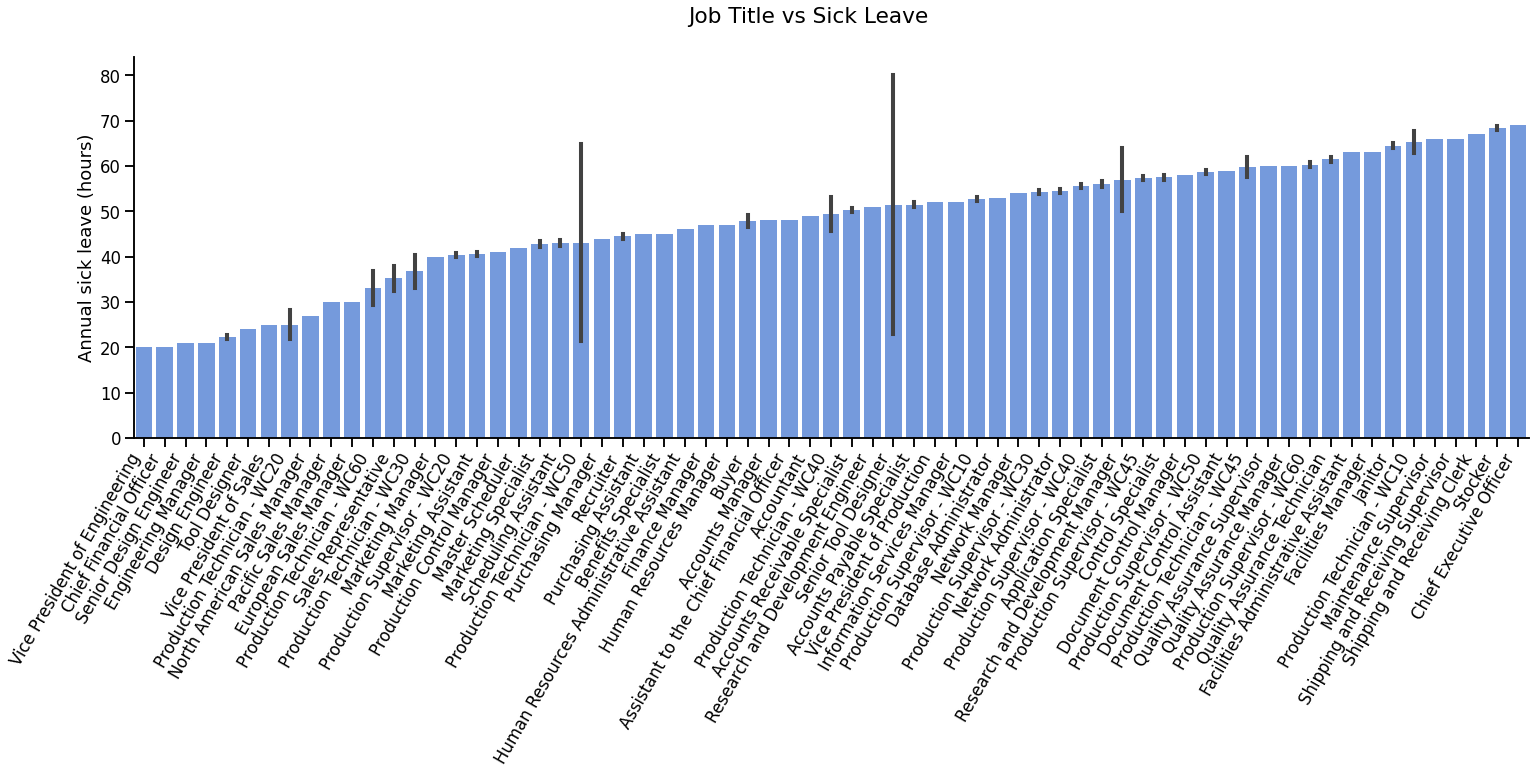

In [13]:
fig, ax = plt.subplots(figsize=(25, 7))
sns.despine()

group_order = (
    df.groupby("job_title")
    .mean()
    .sort_values("sick_leave_hours")
    .index
)

### Plotting ###
sns.barplot(
    y="sick_leave_hours",
    x="job_title",
    data=df,
    order=group_order,
    color='CornflowerBlue',
    dodge=False,
    estimator=np.mean,
    ci="sd",
    ax=ax,
)

### Formatting ###
plt.xticks(rotation=60, ha="right")

ax.set(
    xlabel=None, 
    ylabel="Annual sick leave (hours)"
)
fig.suptitle('Job Title vs Sick Leave')

### Saving ###
fig.savefig(
    "Q4. Sick Leave vs Job Title.png",
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)

In [14]:
job_count = df.groupby("job_title", as_index=False).agg({"id": "count"})

unique_job_count = job_count.shape[0]
print(f"There are {unique_job_count} unique jobs at AdventureWorks")

one_person_roles = (job_count["id"] == 1).sum()
one_person_percent = int(round(100 * (one_person_roles / unique_job_count)))
print(
    f"Of those, {one_person_roles} are job titles held by only one person ({one_person_percent}%)"
)

five_or_more = (job_count["id"] >= 5).sum()
five_plus_percent = int(round(100 * (five_or_more / unique_job_count)))
print(
    f"There are only {five_or_more} job titles held by five or more people ({five_plus_percent}%)"
)

There are 67 unique jobs at AdventureWorks
Of those, 28 are job titles held by only one person (42%)
There are only 10 job titles held by five or more people (15%)


**Observations:**
* 42% of jobs have only a single employee in the role
* Only 15% of job titles have five or more people in that role


Analysis by job title is unfortunately too granular to provide useful insights, and so we have to find another way to produce results. Two options present themselves: analysis by Organisation Level and analysis by Job Department / Department Category

### How is Sick Leave related to Organisation Level?
During data preparation, the CEO was defined to have Organisation Level 0. Level 1 employees answer directly to the CEO, Level 2 employees answer to Level 1, and so on.

In [15]:
(
    df.groupby("organisation_level")
    .agg({"sick_leave_hours": [np.mean, np.std, np.median, "count"]})
    .round(1)
)

sick_leave_hours                   
                               mean   std median count
organisation_level                                    
0                              69.0   NaN   69.0     1
1                              34.8  15.2   32.5     6
2                              45.3  10.2   44.0    27
3                              46.8  12.2   49.0    66
4                              45.0  15.6   45.0   190

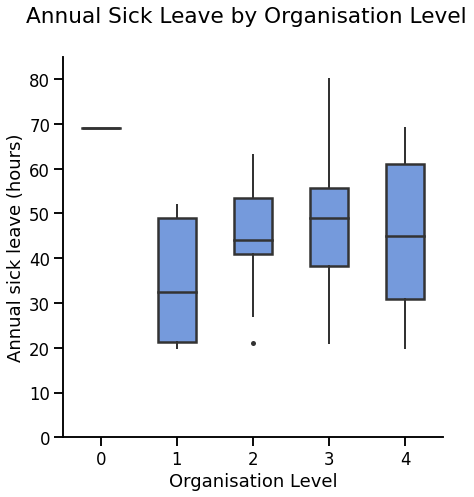

In [16]:
fig, ax = plt.subplots()
sns.despine()

### Plotting ###
sns.boxplot(
    x="organisation_level",
    y="sick_leave_hours",
    data=df,
    color="CornflowerBlue",
    width=0.5,
    showcaps=False,
    flierprops={
        "marker": "o",
        "markerfacecolor": "#333",
        "markeredgecolor": "none",
    },
    boxprops={"linewidth": 2.5, "edgecolor": "#333"},
    medianprops={"linewidth": 2.5, "color": "#333"},
    whiskerprops={"linewidth": 2, "color": "#333"},
    ax=ax,
)

### Formatting ###
ax.set(
    box_aspect=1,
    ylim=(0, 85),
    xlabel='Organisation Level',
    ylabel="Annual sick leave (hours)",
    # title="Annual Sick Leave by Organisation Level",
)
fig.suptitle("Annual Sick Leave by Organisation Level")

### Saving ###
fig.savefig(
    "Q4. Sick Leave vs Organisation Level.png",
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)

**Observations:**
* CEO has significantly higher sick leave than other employees
* Mean and Median sick leave peak in Level 3 employees and decrease as level increases: higher responsibility employees are afforded less sick leave
* No employee has fewer than 20 hours annual sick leave

### How is Sick Leave related to Department Category?
Each of the 67 unique jobs in AdventureWorks belongs to one of 16 job departments, which in turn belong to one of 6 department categories. We first investigate the relationship between sick leave and department category, then sick leave and job department.

In [17]:
group_order = (
    df.groupby("department_category")
    .agg({"sick_leave_hours": [np.mean, np.std, np.median, "count"]})
    .round(1)
    .sort_values(('sick_leave_hours', 'mean'))
)
group_order

sick_leave_hours                   
                                                 mean   std median count
department_category                                                     
Research and Development                         35.4  19.8   23.5    14
Sales and Marketing                              36.3   5.2   37.0    27
Manufacturing                                    44.2  15.0   43.0   185
Executive General and Administration             52.9   9.0   52.0    35
Inventory Management                             53.8  10.1   48.5    18
Quality Assurance                                59.7   1.7   60.0    11

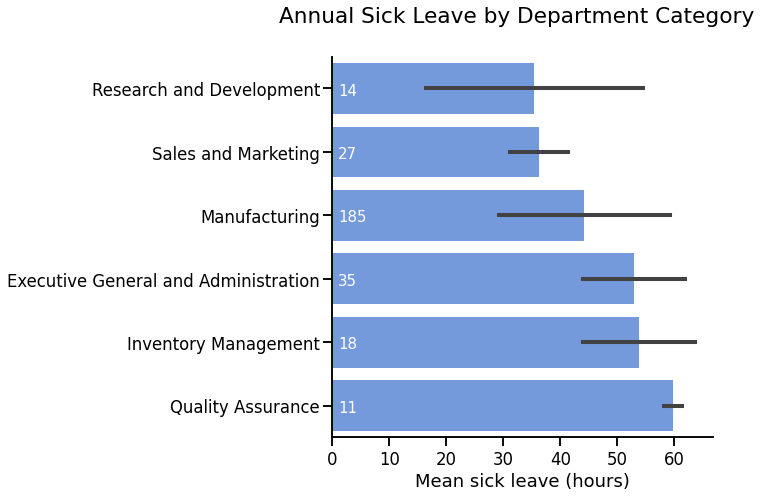

In [18]:
fig, ax = plt.subplots()
sns.despine()

### Plotting ###
sns.barplot(
    x="sick_leave_hours",
    y="department_category",
    data=df,
    ax=ax,
    estimator=np.mean,
    ci='sd',
    color='CornflowerBlue',
    order=group_order.index,
)

### Formatting ###
ax.set(
    box_aspect=1,
    xlabel="Mean sick leave (hours)",
    ylabel=None,
)
fig.suptitle("Annual Sick Leave by Department Category")

for index, group_size in enumerate(group_order[('sick_leave_hours', 'count')]):
    ax.annotate(
        str(group_size),
        (1, index + 0.1),
        color='White',
        fontsize='small'
    )

### Saving ###
fig.savefig(
    "Q4. Sick Leave vs Department Category.png",
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)

Observations:
* Manufacturing is by far the largest category, containing 185 of 290 employees (64%)
* Quality Assurance has both the highest median sick leave and the smallest range

### How is Sick Leave related to Job Department?

In [19]:
group_order = (
    df.groupby("job_department")
    .agg({"sick_leave_hours": [np.mean, np.std, np.median, "count"]})
    .round(1)
    .sort_values(('sick_leave_hours', 'mean'))
)
group_order

sick_leave_hours                   
                                       mean   std median count
job_department                                                
Engineering                            21.5   1.0   21.5     6
Sales                                  33.6   4.1   33.5    18
Tool Design                            37.8  28.2   24.0     4
Marketing                              41.8   1.4   42.0     9
Production Control                     42.5   1.0   42.5     6
Production                             44.3  15.2   43.0   179
Executive                              44.5  34.6   44.5     2
Human Resources                        45.5   1.0   45.5     6
Purchasing                             47.0   1.9   47.0    12
Finance                                49.5   1.6   49.5    10
Research and Development               54.0   6.7   51.0     4
Information Services                   54.5   1.6   54.5    10
Document Control                       58.2   0.8   58.0     5
Quality Assurance                      61.0   0.9   61.0     6
Facilities and Maintenance             64.3   1.1   64.0     7
Shipping and Receiving                 67.5   1.0   67.5     6

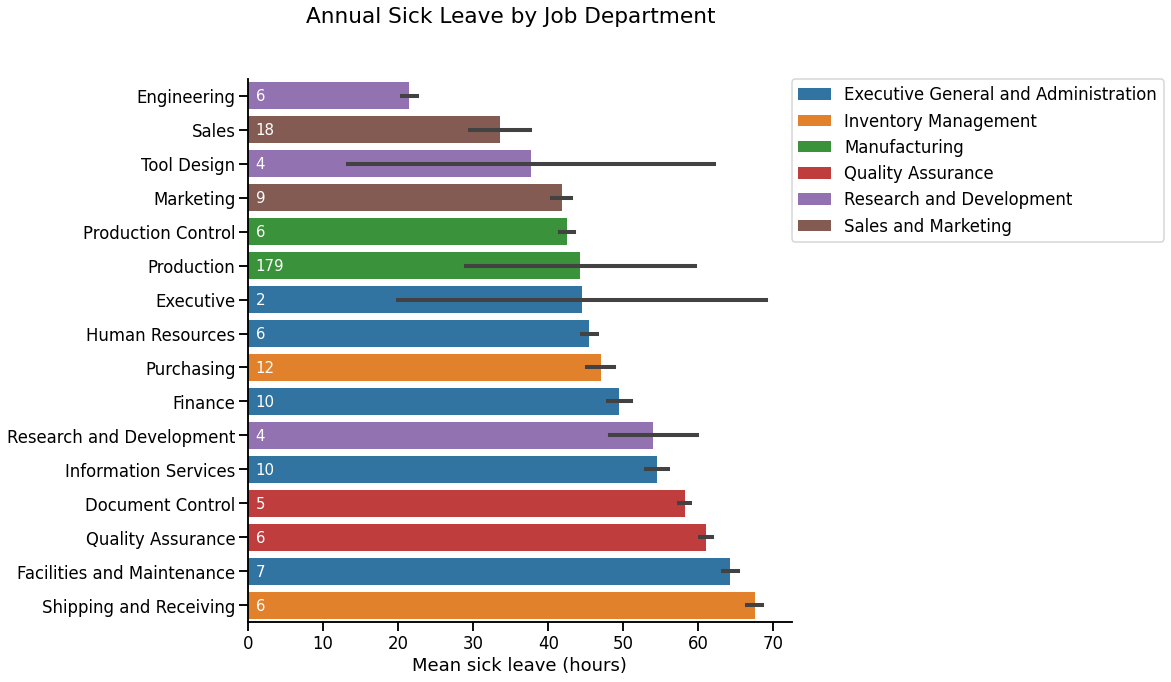

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.despine()

### Plotting ###
sns.barplot(
    x="sick_leave_hours",
    y="job_department",
    data=df,
    ax=ax,
    estimator=np.mean,
    ci='sd',
    hue="department_category",
    dodge=False,
    order=group_order.index,
)

### Formatting ###
ax.set(
    box_aspect=1,
    xlabel="Mean sick leave (hours)",
    ylabel=None,
    title=None,
)
ax.legend(loc=(1, 0.7))
fig.suptitle("Annual Sick Leave by Job Department")

for index, group_size in enumerate(group_order[('sick_leave_hours', 'count')]):
    ax.annotate(
        str(group_size),
        (1, index + 0.15),
        color='White',
        fontsize='small'
    )

### Saving ###
fig.savefig(
    "Q4. Sick Leave vs Job Department.png",
    bbox_inches="tight",
    facecolor='white',
    dpi=150,
)

**Observations:**
* Breakdown by Job Department probably most useful: very small standard deviation for all departments with 5 or more people, with the expection of Production